<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

## Цель

Для интернет-магазина "Викишоп" подготовить модель фильтрации комментариев и описания товаров<br>
Модель должна классифицировать тексты определяя эмоциональный окрас позитивный или негативный <br>
<br>
Критерий оценки качества модели метрика F1, допустимые минимальные значения 0.75<br>
Данные находятся по ссылке https://code.s3.yandex.net/datasets/toxic_comments.csv<br>
В файле два столбца `text и toxic` <br>
Признаки находятся в столбце `text`<br>
Целевой признак `toxic`<br>

## Подготовка

In [1]:
import warnings
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import torch
import transformers 
from tqdm import tqdm
from transformers import BertConfig
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from transformers import BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import TensorDataset, random_split, Subset,  DataLoader
import torch.nn as nn

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Загрузка стоп-слов
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [6]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bigquery_stats  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %sql  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %wandb  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%la

In [37]:
try:
    data = pd.read_csv('toxic_comments.csv')
    import optuna
    from torchvision import transforms
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
    %pip install optuna
    import optuna
    from optuna.integration import LightGBMPruningCallback
    %pip install torchvision
    from torchvision import transforms

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


In [38]:
# зададим константы
NAME_DATA = 'taxi.csv'
RANDOM_STATE = 6568

In [39]:
# Инициализируем токенизатор
tokenizer = nltk.tokenize.WordPunctTokenizer()

# Токенизируем каждый текст и подсчитываем количество слов
data['word_count'] = data['text'].apply(lambda x: len(tokenizer.tokenize(x.lower())))

data = data.loc[data['word_count'] < 512]

In [40]:
# data = data.sample(n=3000).reset_index(drop=True)
data = data.sample(n=6000, replace=False).reset_index(drop=False)

In [41]:
# X_train, X_test, y_train, y_test = train_test_split(features, data['toxic'], test_size=0.2, stratify=data['toxic'])

In [42]:
def isna_count_procent(data, name):
    '''
    Создадим таблицу с пропусками в  дата сете
    Всего три столбца 
    1. процентное отношение пропусков к длине
    2. количество пропусков в единицах
    3. тип
    Далее блок выводит всю доступную информацию о данных 
    Несколько первых строк
    Описание числовых признаков
    Описание категориальных признаков
    
    '''
    pd.set_option('display.max_rows', None)
    isna_columns = data.isna().sum() > 0
    type_ = pd.DataFrame(data[data.isna().sum()[isna_columns].index.tolist()].dtypes)[0]
    isna_columns = pd.DataFrame([data.isna().sum()[isna_columns]/data.shape[0], data.isna().sum()[isna_columns]]).T
    isna_columns = isna_columns.rename(columns={0: 'procent', 1: 'count'})
    # isna_columns['type'] = type_[0]
    isna_columns['count'] = isna_columns['count'].map('{:,.2f}'.format)
    isna_columns['procent'] = isna_columns['procent'].map('{:,.2%}'.format)
    isna_columns = isna_columns.sort_values('procent', ascending=False)
    # блок показывае всё о данных
    display(data.head())
    print('#'*55)
    print()
    display(data.describe(include=np.number))
    print()
    display(data.describe(include=np.object_))
    print('#'*55)
    print()
    data.info()
    print('#'*55)
    isna = data.isna().sum().sum()
    isna_procent = len(isna_columns)/data.shape[1]
    s = data.duplicated().sum()
    print(f'Количество дубликатов в данных  равно {s}')
    print()
    print(f'Всего пропусков в {name} {isna:,} шт. в {len(isna_columns)} столбцах')
    print(f'В процентном отношении {isna_procent:.2%} от {data.shape[1]:,} признаков')
  
    print()
    display(isna_columns)
    return isna_columns

In [43]:
isna_count_procent(data, NAME_DATA)

,index,Unnamed: 0,text,toxic,word_count
0,140133,140285,"""* Response to anonymous 71.226.23.207. To re...",0,235
1,107021,107118,"""\n\n Sandbox 20 \n\nHi A.B,\nSince you've bee...",0,39
2,125780,125911,"""\n\n \n\nYour request to be unblocked has be...",0,35
3,10239,10252,"""\n\nPlease stop. If you continue to vandalize...",0,22
4,101708,101805,In that case why not just tweak the wording sl...,0,54


#######################################################



,index,Unnamed: 0,toxic,word_count
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,79592.783500,79672.793333,0.101000,71.693333
std,46192.395274,46237.622155,0.301354,79.984283
min,4.000000,4.000000,0.000000,2.000000
25%,39042.750000,39092.750000,0.000000,21.000000
50%,80714.500000,80790.500000,0.000000,43.000000
75%,119484.250000,119589.250000,0.000000,88.000000
max,159274.000000,159433.000000,1.000000,511.000000


,text
count,6000
unique,6000
top,"""* Response to anonymous 71.226.23.207. To re..."
freq,1


#######################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       6000 non-null   int64 
 1   Unnamed: 0  6000 non-null   int64 
 2   text        6000 non-null   object
 3   toxic       6000 non-null   int64 
 4   word_count  6000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 234.5+ KB
#######################################################
Количество дубликатов в данных  равно 0

Всего пропусков в taxi.csv 0 шт. в 0 столбцах
В процентном отношении 0.00% от 5 признаков



,procent,count


,procent,count


В данных два столбца которые мы ожидали увидеть и <br>
Третий столбец о которм заказчик нас не предупредил<br>
Проверим является ли столбец `Unnamed: 0` индексом

In [44]:
column_array = np.array(data['Unnamed: 0'])

# Вычисление разностей между элементами массива
diff_array = np.diff(column_array)

# Проверка на непрерывность
if np.all(diff_array == 1):
    print("Столбец является непрерывным.")
else:
    print("Столбец не является непрерывным.")

Столбец не является непрерывным.


Информация в столбце `Unnamed: 0` не понятна ценности для выполнения задания не составляет<br>
Удалим этот столбец

In [45]:
data = data.drop(columns='Unnamed: 0', axis=1)

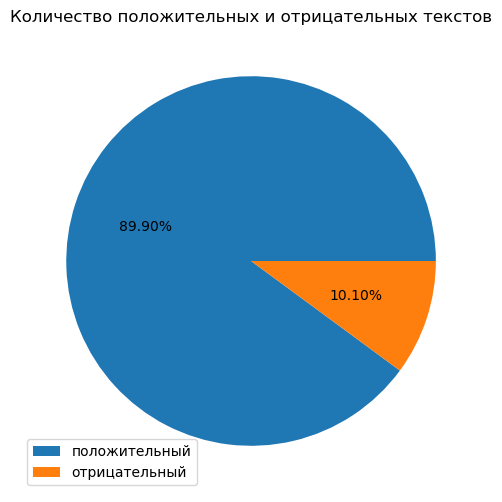

In [46]:
fig, (ax1) = plt.subplots( figsize=(8,6));

data['toxic'].value_counts().plot.pie( labels=None, ylabel='', autopct='%1.2f%%', legend=True, ax=ax1);
ax1.legend(['положительный', 'отрицательный'],loc='lower left');
ax1.set_title('Количество положительных и отрицательных текстов');

Целевой признак имеет большую диспропорцию, при разбиении на обучающую и проверочную выборки обязательно <br>
Выполнить балансировку классов

In [47]:
def preprocess_text(text):
    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)
    
    # Приведение текста к нижнему регистру
    text = text.lower()
    
    # Токенизация текста
    tokens = word_tokenize(text)
    
#     # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    

    text = ' '.join(filtered_tokens)
    return text

In [48]:
%%time
data['processed_text'] = data['text'].apply(preprocess_text)

CPU times: user 2.73 s, sys: 126 ms, total: 2.85 s
Wall time: 2.87 s


In [49]:
data.shape

(6000, 5)

Построим график столбца `toxic` посмотрим на распределение

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [51]:
# разделение на тренировочный и тестовый наборы данных
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['toxic'])

train_data_token = tokenizer.batch_encode_plus(train_data['processed_text'].tolist(), padding=True, truncation=True, return_tensors='pt')
test_data_token = tokenizer.batch_encode_plus(test_data['processed_text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# объединение закодированных тензоров и меток в один TensorDataset
dataset_train_data = TensorDataset(train_data_token['input_ids'], train_data_token['attention_mask'], torch.tensor(train_data['toxic'].values))
dataset_test_data = TensorDataset(test_data_token['input_ids'], test_data_token['attention_mask'], torch.tensor(test_data['toxic'].values))

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=2, num_training_steps=len(train_data)*25)

In [52]:

# инициализация DataLoader
batch_size = 20 # количество элементов в батче
train_loader = DataLoader(dataset_train_data, batch_size=batch_size)
model.to(device)

# цикл обучения
for epoch in range(5):
    total_loss = 0
    model.train()
    
    for batch in tqdm(train_loader):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
       
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print('Epoch:', epoch+1, 'Training Loss:', avg_train_loss)
   
    model_file = f"model_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), model_file)
    
    test_loader = DataLoader(dataset_test_data, batch_size=batch_size, shuffle=False)
    
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for batch in tqdm(test_loader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predicted_label = torch.argmax(outputs[0], dim=1).cpu().numpy()
            true_label = labels
            y_pred.extend(predicted_label.tolist())
            y_true.extend(true_label.tolist())

        print('Epoch:', epoch+1, 'Classification Report:')
        print(f1_score(y_true, y_pred))

100%|██████████| 240/240 [01:20<00:00,  3.00it/s]


Epoch: 1 Training Loss: 0.18541043904066706


100%|██████████| 60/60 [00:05<00:00, 10.33it/s]


Epoch: 1 Classification Report:
0.7822222222222223


100%|██████████| 240/240 [01:20<00:00,  3.00it/s]


Epoch: 2 Training Loss: 0.08247746335109696


100%|██████████| 60/60 [00:05<00:00, 10.30it/s]


Epoch: 2 Classification Report:
0.8090909090909091


100%|██████████| 240/240 [01:20<00:00,  3.00it/s]


Epoch: 3 Training Loss: 0.04377102413369963


100%|██████████| 60/60 [00:05<00:00, 10.33it/s]


Epoch: 3 Classification Report:
0.7768595041322314


100%|██████████| 240/240 [01:20<00:00,  3.00it/s]


Epoch: 4 Training Loss: 0.02684932154515991


100%|██████████| 60/60 [00:05<00:00, 10.30it/s]


Epoch: 4 Classification Report:
0.7826086956521738


100%|██████████| 240/240 [01:20<00:00,  3.00it/s]


Epoch: 5 Training Loss: 0.021619055920503647


100%|██████████| 60/60 [00:05<00:00, 10.29it/s]


Epoch: 5 Classification Report:
0.7092198581560283


In [55]:
encoded_texts = tokenizer.batch_encode_plus(data['processed_text'].tolist(), padding=True, truncation=True, return_tensors='pt').to(device)

batch_size = 20

# Инициализация пустого тензора для хранения предсказанных классов
predicted_classes = torch.empty((len(encoded_texts['input_ids']),), dtype=torch.long)
model.to(device)
# Передача данных порциями в модель
for i in tqdm(range(0, len(encoded_texts['input_ids']), batch_size)):
    inputs_pred = {
        'input_ids': encoded_texts['input_ids'][i:i+batch_size],
        'attention_mask': encoded_texts['attention_mask'][i:i+batch_size],
    }
    outputs_pred = model(**inputs_pred)
    
    batch_predicted_classes = torch.argmax(outputs_pred.logits, dim=-1)
    predicted_classes[i:i+batch_size] = batch_predicted_classes

# Вывод предсказанных классов
print(f1_score(data['toxic'], predicted_classes))

100%|██████████| 300/300 [00:32<00:00,  9.31it/s]

0.9130775254502741


## Обучение

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны